## Busines Understanding

Ini merupakan mini project untuk melihat secara sekilas bagaimana ulasan pengguna aplikasi jenius dengan menjawab beberapa pertanyaan bisnis berikut.

SCORE & REVIEWS
1. Bagaimana penilaian skor secara keseluruhan dari aplikasi jenius
2. Bagaimana sentimen ulasan aplikasi? Berapa banyak yang positif, netral, dan negatif?

USER ENGAGEMENT
1. Berapa persen pengguna yang “thumbsUp” atau mendukung ulasan?
2. Ulasan seperti apa yang banyak mendapat thumbsUp?
Apakah ada hubungan antara score dengan thumbsUp?

APP VERSIONS
1. Bagaimana skor across all different versions?
2. Apakah ada versi app tertentu yang mendapat review sangat baik atau sangat buruk?

RESPONSE EFFECTIVENESS
1. Berapa rata rata waktu ulasan dibalas?
2. Apakah ada pola pada ulasan yang dibalas dan tidak dibalas?

Proyek ini selanjutnya dapat dikembangkan lebih lanjut lagi dengan tujuan dan pengolahan data yang lebih advanced untuk mendapatkan informasi lebih mendalam maupun pemodelan yang mendukung pengambilan keputusan


## Data Understanding

### Scrap data

In [ ]:
pip install google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google_play_scraper import app, Sort, reviews

In [ ]:
result = app(
    'com.btpn.dc',
    lang='id',
    country='id',
)

result

{'title': 'Jenius',
 'description': 'Cara mudah atur kehidupan/keuangan dengan aplikasi serta kartu debit dan kartu kredit Visa.\r\n \r\nLebih dari 4.000.000 pengguna telah mulai mewujudkan kehidupan finansial yang lebih baik bersama Jenius. \r\n \r\nSemua kebutuhan finansialmu, dari transaksi, tabungan, kredit, investasi, hingga report keuangan, kini bisa kamu akses di 1 tempat tanpa harus pindah aplikasi. \r\n \r\nSiap mulai mempermudah kehidupan keuanganmu?\r\nDownload aplikasi Jenius, registrasi dan aktivasi rekening yang bisa kamu lakukan di mana saja dengan cepat menggunakan fitur Pengenalan Wajah.\r\n \r\nDengan m-Card (kartu debit utama Jenius) beserta 3 kartu debit tambahan, kamu bisa transaksi di berbagai merchant Visa di berbagai negara. Kamu juga akan mendapatkan e-Card juga bisa kamu pakai untuk bayar tagihan streaming film, musik, game, bayar/beli aplikasi dan lainnya.\r\nJenius Award akan membuat transfer dan tarik tunai makin hemat sesuai level. Dapatkan bebas biaya unt

In [ ]:
import json
from time import sleep
from typing import List, Optional, Tuple

from google_play_scraper import Sort
from google_play_scraper.constants.element import ElementSpecs
from google_play_scraper.constants.regex import Regex
from google_play_scraper.constants.request import Formats
from google_play_scraper.utils.request import post

MAX_COUNT_EACH_FETCH = 199


class _ContinuationToken:
    __slots__ = (
        "token",
        "lang",
        "country",
        "sort",
        "count",
        "filter_score_with",
        "filter_device_with",
    )

    def __init__(
        self, token, lang, country, sort, count, filter_score_with, filter_device_with
    ):
        self.token = token
        self.lang = lang
        self.country = country
        self.sort = sort
        self.count = count
        self.filter_score_with = filter_score_with
        self.filter_device_with = filter_device_with


def _fetch_review_items(
    url: str,
    app_id: str,
    sort: int,
    count: int,
    filter_score_with: Optional[int],
    filter_device_with: Optional[int],
    pagination_token: Optional[str],
):
    dom = post(
        url,
        Formats.Reviews.build_body(
            app_id,
            sort,
            count,
            "null" if filter_score_with is None else filter_score_with,
            "null" if filter_device_with is None else filter_device_with,
            pagination_token,
        ),
        {"content-type": "application/x-www-form-urlencoded"},
    )
    match = json.loads(Regex.REVIEWS.findall(dom)[0])

    return json.loads(match[0][2])[0], json.loads(match[0][2])[-2][-1]


def reviews(
    app_id: str,
    lang: str = "en",
    country: str = "us",
    sort: Sort = Sort.NEWEST,
    count: int = 100,
    filter_score_with: int = None,
    filter_device_with: int = None,
    continuation_token: _ContinuationToken = None,
) -> Tuple[List[dict], _ContinuationToken]:
    sort = sort.value

    if continuation_token is not None:
        token = continuation_token.token

        if token is None:
            return (
                [],
                continuation_token,
            )

        lang = continuation_token.lang
        country = continuation_token.country
        sort = continuation_token.sort
        count = continuation_token.count
        filter_score_with = continuation_token.filter_score_with
        filter_device_with = continuation_token.filter_device_with
    else:
        token = None

    url = Formats.Reviews.build(lang=lang, country=country)

    _fetch_count = count

    result = []

    while True:
        if _fetch_count == 0:
            break

        if _fetch_count > MAX_COUNT_EACH_FETCH:
            _fetch_count = MAX_COUNT_EACH_FETCH

        try:
            review_items, token = _fetch_review_items(
                url,
                app_id,
                sort,
                _fetch_count,
                filter_score_with,
                filter_device_with,
                token,
            )
        except (TypeError, IndexError):
            if continuation_token != None:
              token = continuation_token.token
            continue

        for review in review_items:
            result.append(
                {
                    k: spec.extract_content(review)
                    for k, spec in ElementSpecs.Review.items()
                }
            )

        _fetch_count = count - len(result)

        if isinstance(token, list):
            token = None
            break

    return (
        result,
        _ContinuationToken(
            token, lang, country, sort, count, filter_score_with, filter_device_with
        ),
    )


def reviews_all(app_id: str, sleep_milliseconds: int = 0, **kwargs) -> list:
    kwargs.pop("count", None)
    kwargs.pop("continuation_token", None)

    continuation_token = None

    result = []

    while True:
        _result, continuation_token = reviews(
            app_id,
            count=MAX_COUNT_EACH_FETCH,
            continuation_token=continuation_token,
            **kwargs
        )

        result += _result

        if continuation_token.token is None:
            break

        if sleep_milliseconds:
            sleep(sleep_milliseconds / 1000)

    return result

In [ ]:
rvws, continuation_token = reviews(
    'com.btpn.dc',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    count = 20000
)

In [ ]:
df = pd.DataFrame(np.array(rvws),columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))

In [ ]:
df.to_excel('jenius_app_reviews_newest.xlsx', index=False)

### EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import re
import nltk
import json
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import plotly.express as px
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# read the dataset
path ='/content/drive/MyDrive/Datasets/jenius_app_reviews_newest_scrapped.xlsx'

df = pd.read_excel(path)

df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,3da298d6-1035-4036-8849-fbe37a655e03,Wahyudi Boxir,https://play-lh.googleusercontent.com/a-/ALV-U...,Gagal mulu pengajuan udah hampir 1 thun ngajui...,1,0,4.4.0,2024-08-25 14:12:21,NaN,NaT,4.4.0
1,ad3720d5-ff15-4e1f-898f-1db55cd0af3b,lismanthocotua lisman,https://play-lh.googleusercontent.com/a-/ALV-U...,mantap,5,0,NaN,2024-08-25 13:07:07,NaN,NaT,NaN
2,c270cd76-ddc0-44a3-89c6-acb3537d58cb,Febriansyah Achmad Hidayat,https://play-lh.googleusercontent.com/a-/ALV-U...,Mantap! Jenius terus update hal hal baru dan b...,5,0,NaN,2024-08-25 07:36:02,NaN,NaT,NaN
3,e9612e4f-3ea7-4773-b57c-a1e46c1c263e,Iyunk Bontot,https://play-lh.googleusercontent.com/a-/ALV-U...,Aplikasi yg paling terjelek yg pernah saya tem...,1,0,NaN,2024-08-25 07:04:16,NaN,NaT,NaN
4,6765127f-34aa-4603-93b9-9531606a42a6,Sabil Hasan,https://play-lh.googleusercontent.com/a-/ALV-U...,Luar biasa keren banget Seumur Hidup baru kali...,1,0,4.4.1,2024-08-25 04:35:24,NaN,NaT,4.4.1


In [ ]:
df.shape

(20000, 11)

Data yang digunakan terdiri dari 20000 record dan 11 kolom

In [ ]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')



*   reviewId: unique ID dari review
*   userName: username akun pemberi review
*   userImage: link user image
*   content: konten review (isi/komentar ulasan)
*   score: rating (1-5)
*   thumbsUpCount: berapa like dari review (semakin banyak thumbs up => helpful/likes the review)
*   reviewCreatedVersion: thhis refers to the version of the app that the user was using when they wrote the review. It helps contextualize the review based on the app's development stage at that time.
*   at: tanggal ulasan diberikan
*   replyContent: balasan dari developer jenius utk sebuah ulasan
*   repliedAt: tanggal review dibalas
*   appVersion: versi aplikasi yang saat ini terinstall di perangkat user


In [ ]:
df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,5527
at,0
replyContent,18440
repliedAt,18440


In [ ]:
df.dtypes

,0
reviewId,object
userName,object
userImage,object
content,object
score,int64
thumbsUpCount,int64
reviewCreatedVersion,object
at,datetime64[ns]
replyContent,object
repliedAt,datetime64[ns]


In [ ]:
df.describe()

,score,thumbsUpCount,at,repliedAt
count,20000.000000,20000.000000,20000,1560
mean,3.540300,1.251550,2023-04-09 13:00:22.273649920,2022-10-23 04:04:14.173717760
min,1.000000,0.000000,2022-04-23 07:13:23,2016-10-21 12:38:49
25%,1.000000,0.000000,2022-10-05 11:23:19.249999872,2022-08-10 01:00:03.500000
50%,5.000000,0.000000,2023-01-14 04:18:54.500000,2022-09-19 02:28:51.500000
75%,5.000000,0.000000,2023-12-14 13:57:27.500000,2023-01-03 00:46:38.500000
max,5.000000,562.000000,2024-08-25 14:12:21,2024-04-05 04:47:30
std,1.832387,11.103114,NaN,NaN


#### Review time and scoring

In [ ]:
print(f"Start date: {df['at'].min()} \nLatest date: {df['at'].max()}")

Start date: 2022-04-23 07:13:23 
Latest date: 2024-08-25 14:12:21


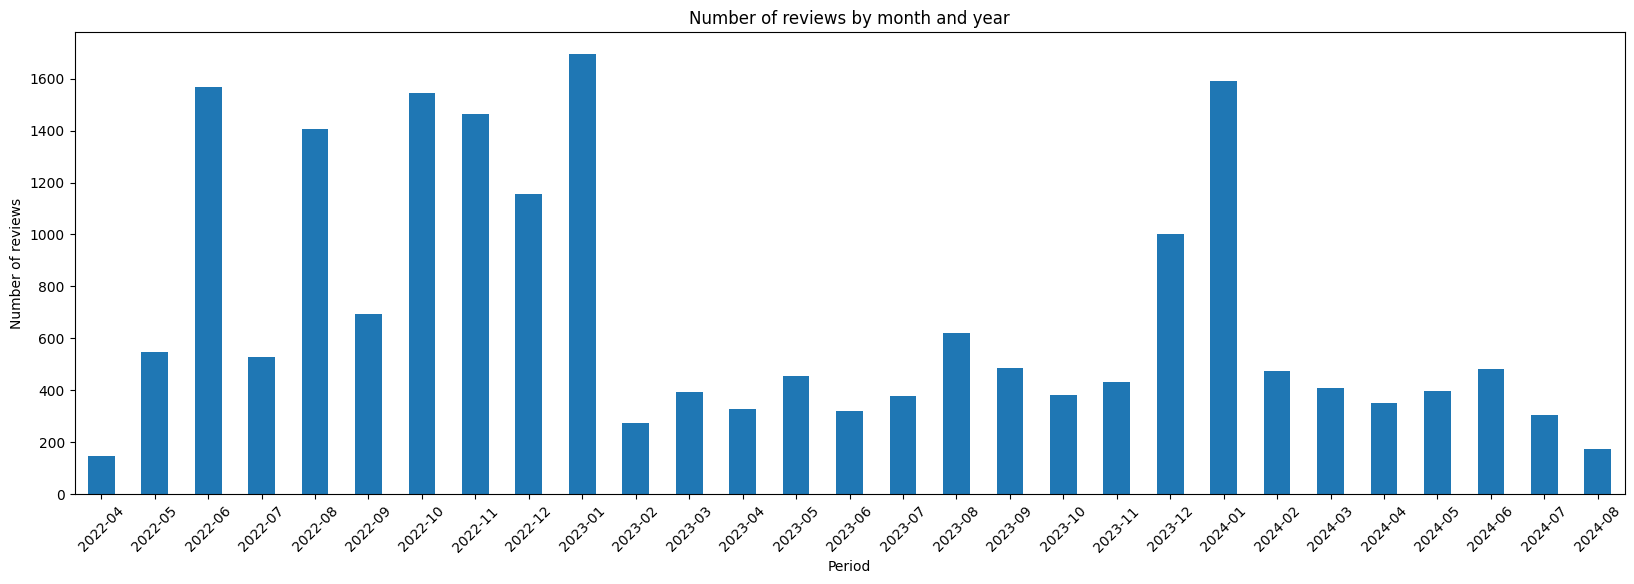

In [ ]:
df['year_month'] = df['at'].dt.to_period('M')
review_by_month_year = df.groupby('year_month').size()


plt.figure(figsize=(20,6))
review_by_month_year.plot(kind='bar')
plt.title("Number of reviews by month and year")
plt.xlabel("Period")
plt.ylabel("Number of reviews")
plt.xticks(rotation=45)
plt.show()

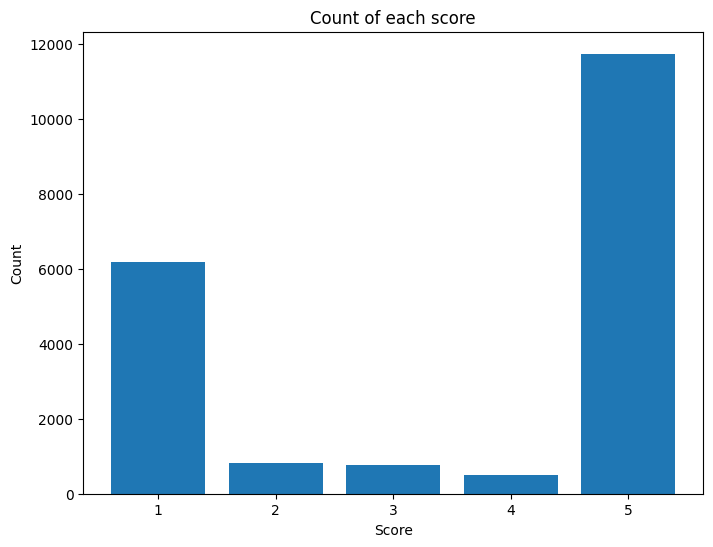

In [ ]:
score_counts = df['score'].value_counts().reset_index()
score_counts.columns = ['score', 'count']


plt.figure(figsize=(8,6))
plt.bar(score_counts['score'], score_counts['count'])
plt.title("Count of each score")
plt.xlabel('Score')
plt.ylabel('Count')

plt.show()

Dapat disimpulkan bahwa kebanyakan pengguna memberikan review pada extreme values yaitu 1 atau 5 (buruk sekali atau baik sekali)

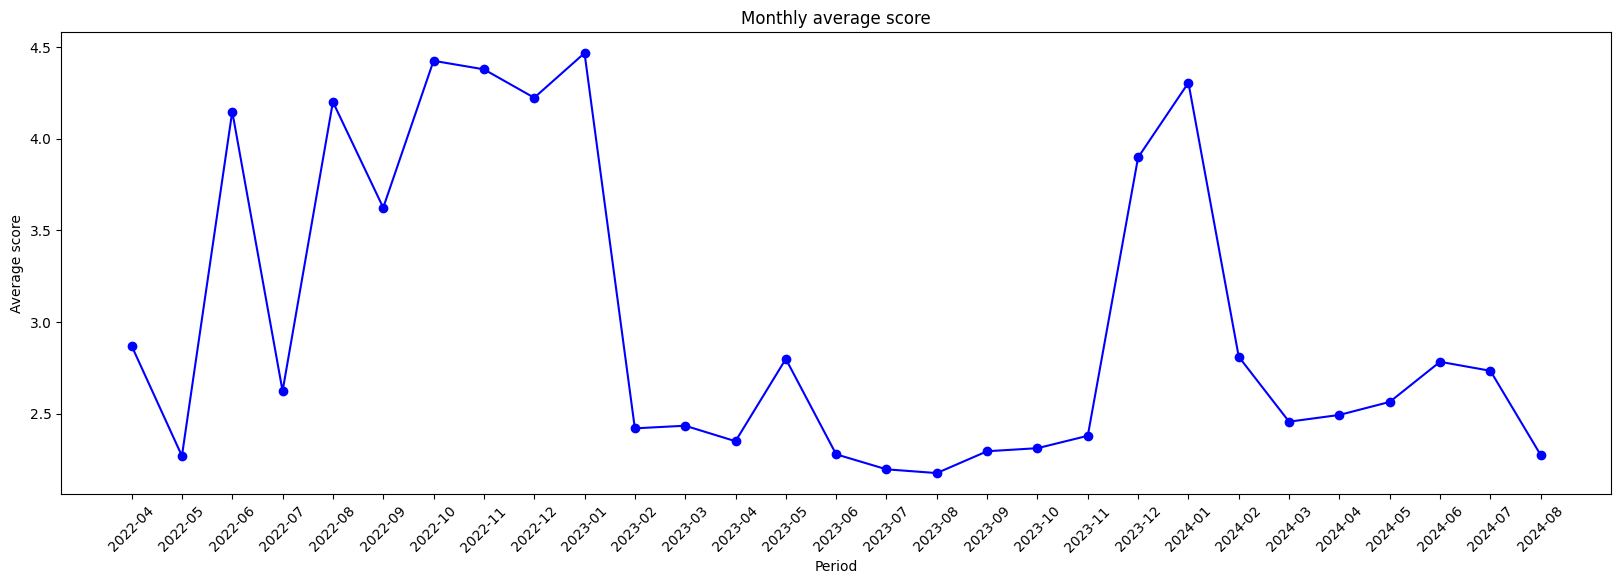

In [ ]:
# monthly average score
monthly_avg_score = df.groupby('year_month')['score'].mean().reset_index()

plt.figure(figsize=(20,6))
plt.plot(monthly_avg_score['year_month'].astype(str), monthly_avg_score['score'], marker='o', linestyle='-', color='blue')
plt.xlabel("Period")
plt.ylabel('Average score')
plt.xticks(rotation=45)
plt.title('Monthly average score')

plt.show()



#### Content

In [ ]:
top_5_thumbsUp = df[['content', 'thumbsUpCount']].sort_values(by='thumbsUpCount', ascending=False).head(5)
top_5_thumbsUp

,content,thumbsUpCount
8392,"Nama aplikasinya jenius, kedengarannya sangat keren dan meyakinkan, tapi realitanya sangat jauh dari ekspektasi, daftar aja sulitnya setengah mati, ribet gk ketulungan, mending kalau berhasil, semua persyaratan sudah dipenuhi, video call berkali-kali gagal, terus saja mengulang, cape dech menghabiskan waktu dan menyita energi. Saya sudah banyak menginstal aplikasi sejenis, prosesnya mudah dan gk ribet, nyaman serta bisa langsung aktif. inimah boro-boro, menyebalkan iya berhasil kagak.",562
3628,"Apa-apaan sihh saldo berkurang otomatis, & jumlahnya nggak masuk akal, keterangannya pun tidak jelas untuk apa. Nyesel banget buka rekening disini, udah kyc nya susahnya minta ampun, prosesnya lama, aplikasinyapun kurang lancar. SANGAT MENGECEWAKAN!!!! HATI² BUAT KALIAN YANG MAU DOWNLOAD APLIKASI INI!!!",451
8403,Saya mengalami problem aplikasi tidak bisa login karena aplikasi masih terpasang diperangkat lain (aktualnya diperangkat lain sudah dihapus karena hp direset). Saran: Untuk bisa login diperangkat yang baru tolong verifikasi lewat sms/email/scan wajah menurutku sudah cukup. Tidak perlu tlp ke call center. Saya sudah telp Call center tapi cuma habisin pulsa aja.,400
7469,"Aplikasi terlalu lambat, verifikasi wajah gagal terus tol**l. Bisa gak cocok sudah jelas2 orang yang sama aneh. Kalau blum siap untuk buat system lebih baik di perbaiki dulu sampai bener. Biar penggunanya juga nyaman.",371
19546,"Aplikasi nya menyebalkan, buat masuk ke aplikasi nya aja lama banget. Pas instal ulang dengan password dan email sebelumnya, pas masukin kode OTP malah katanya sesi waktu habis. Begitu aja terus enggak kelar kelar, dan pas cek via ATM bersama atau Link juga enggak bisa diproses transaksi nya. Tolong di perbaiki lagi aplikasi nya dong",360


Dari banyak data berdasarkan skor, skor 5 memiliki data yang paling banyak. Namun dari top 5 thumbsUpCount semuanya merupakan review negatif. Kebanyakan pengguna complaint gagal verifikasi, daftar ribet, saldo berkurang, aplikasi lambat.

array([[<Axes: title={'center': 'len_review_chars'}>,
        <Axes: title={'center': 'word_count_review'}>]], dtype=object)

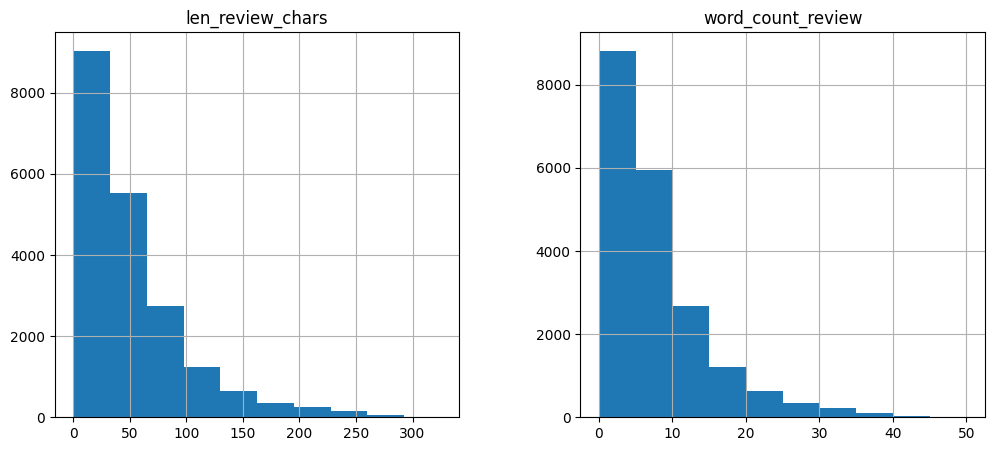

In [ ]:
# review len and word count
df['len_review_chars'] = df['content'].apply(len)
df['word_count_review'] = df['content'].apply(lambda x: len(str(x).split()))

df[['len_review_chars', 'word_count_review']].hist(figsize=(12,5))

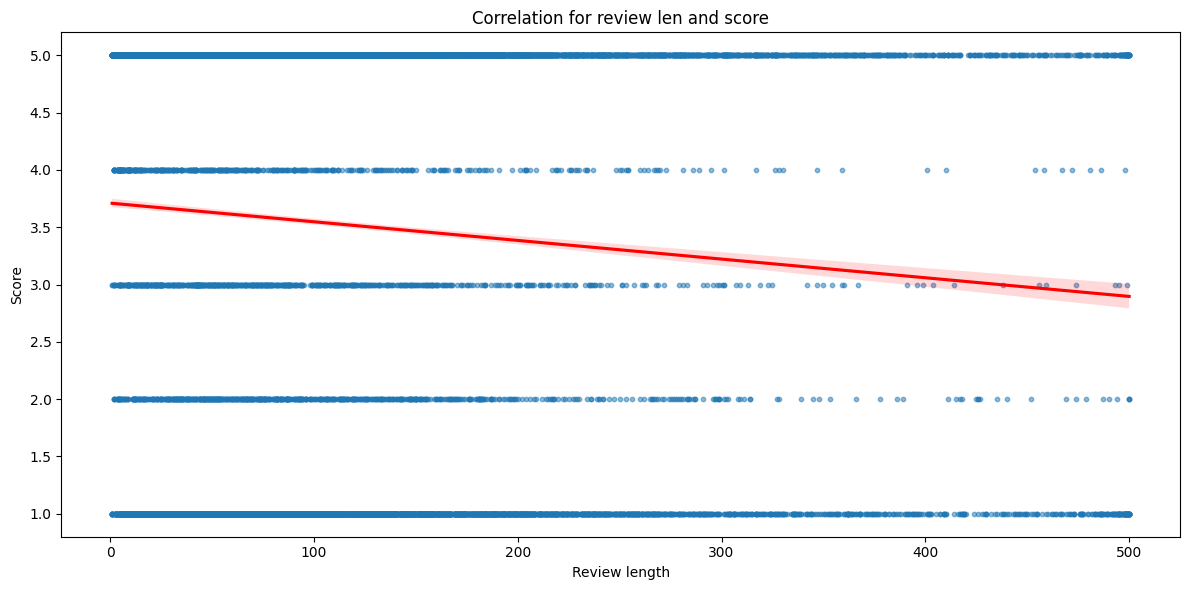

In [ ]:
# correlation between len of the review and score
plt.figure(figsize=(12,6))

# add a trendline
sns.regplot(x='len_review_chars', y='score', data=df, scatter_kws={'s':10, 'alpha':0.5}, line_kws={'color':'red'})

plt.xlabel("Review length")
plt.ylabel("Score")
plt.title('Correlation for review len and score')
plt.tight_layout()
plt.show()

In [ ]:
has_thumbsUp = len(df[df['thumbsUpCount'] > 0])
total_reviews = len(df)


thumbsUp_percentage = (has_thumbsUp / total_reviews) * 100
print('Percentage of reviews with thumbs up: ', thumbsUp_percentage)

Percentage of reviews with thumbs up 18.175


In [ ]:
# calculate correlation between score and thumbsupcount

correlation = df[['score', 'thumbsUpCount']].corr().iloc[0,1]
print(f"Correlation between score and thumbs up count: {correlation: .2f}")

Correlation between score and thumbs up count: -0.06


Nilai yang menunjukkan hampir 0, berarti hampir tidak ada relationship antara thumbs up count dengan score. Tidak adanya hubungan yang menyatakan bahwa semakin tinggi score, maka semakin banyak pula thumbs up count. Secara general (walaupun lemah), tanda negatif menunjukkan bahwa semakin rendah score, semakin banyak thumbs up count. Secara keseluruhan, disimpulkan bahwa thumbs up count dan score tidak berkolerasi kuat, faktor2 lain dapat mempengaruhi thumbsupcount, seperti content review, dll

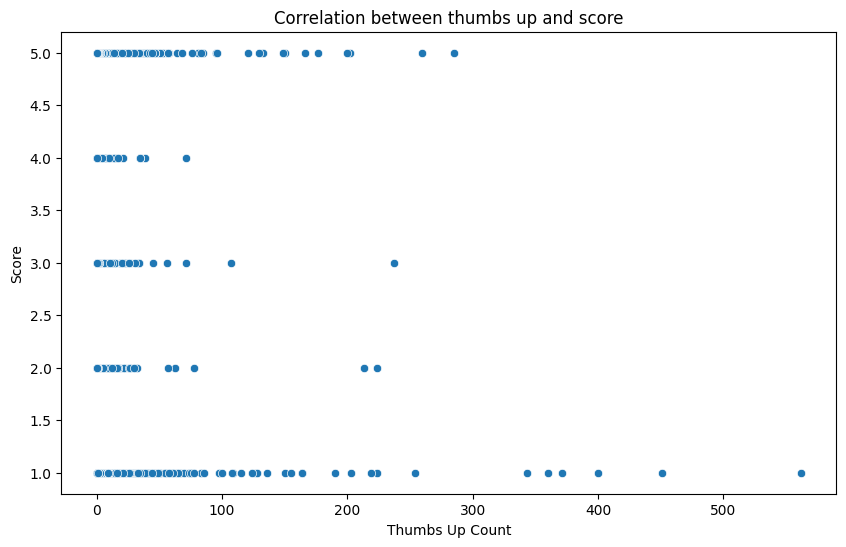

In [ ]:
# visualize the correlation

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='thumbsUpCount', y='score')
plt.title('Correlation between thumbs up and score')
plt.xlabel('Thumbs Up Count')
plt.ylabel('Score')
plt.show()

#### Reply content

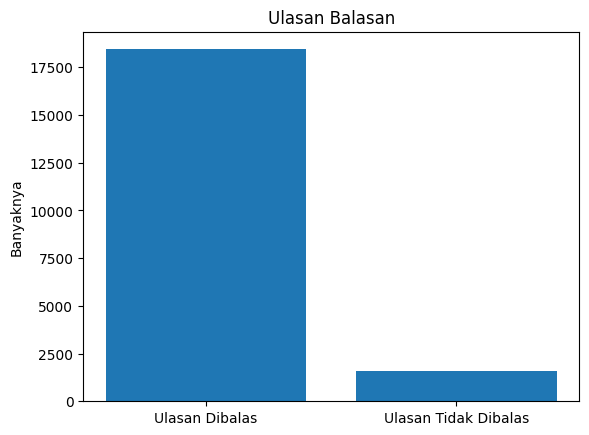

In [ ]:
replied_review = df['repliedAt'].isna().sum()
unreplied_review = df['repliedAt'].notna().sum()

plt.bar(['Ulasan Dibalas', 'Ulasan Tidak Dibalas'], [replied_review, unreplied_review])
plt.ylabel('Banyaknya')
plt.title("Ulasan Balasan")

plt.show()

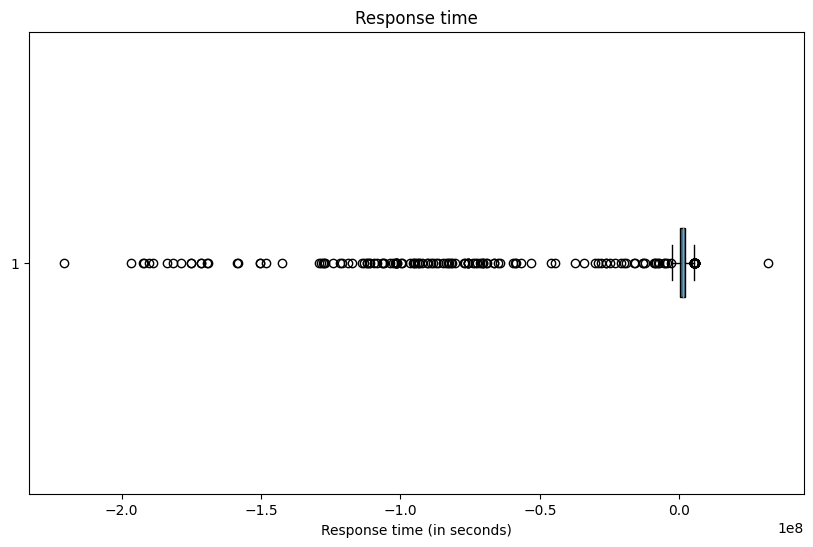

In [ ]:
# time difference from review posted and reply
df['response_time'] = df['repliedAt'] - df['at']
df['response_time'] = df['response_time'].dt.total_seconds()

plt.figure(figsize=(10,6))
plt.boxplot(df['response_time'].dropna(), vert=False, patch_artist=True)
plt.xlabel('Response time (in seconds)')
plt.title('Response time')
plt.show()

In [ ]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,3da298d6-1035-4036-8849-fbe37a655e03,Wahyudi Boxir,https://play-lh.googleusercontent.com/a-/ALV-U...,gagal melulu pengajuan mengajukan gagal melulu...,1,0,4.4.0,2024-08-25 14:12:21,NaN,NaT,4.4.0
1,ad3720d5-ff15-4e1f-898f-1db55cd0af3b,lismanthocotua lisman,https://play-lh.googleusercontent.com/a-/ALV-U...,mantap,5,0,NaN,2024-08-25 13:07:07,NaN,NaT,NaN
2,c270cd76-ddc0-44a3-89c6-acb3537d58cb,Febriansyah Achmad Hidayat,https://play-lh.googleusercontent.com/a-/ALV-U...,mantap update berinovasi ditunggu,5,0,NaN,2024-08-25 07:36:02,NaN,NaT,NaN
3,e9612e4f-3ea7-4773-b57c-a1e46c1c263e,Iyunk Bontot,https://play-lh.googleusercontent.com/a-/ALV-U...,terjelek temuin beda bank digitalain menyarank...,1,0,NaN,2024-08-25 07:04:16,NaN,NaT,NaN
4,6765127f-34aa-4603-93b9-9531606a42a6,Sabil Hasan,https://play-lh.googleusercontent.com/a-/ALV-U...,keren seumur registrasi ketahap wawancara dive...,1,0,4.4.1,2024-08-25 04:35:24,NaN,NaT,4.4.1


In [ ]:
df.dtypes

#### App version

In [ ]:
df['version'] = df['appVersion'].str.split('.').str[:2].str.join('.')

In [ ]:
df.dtypes

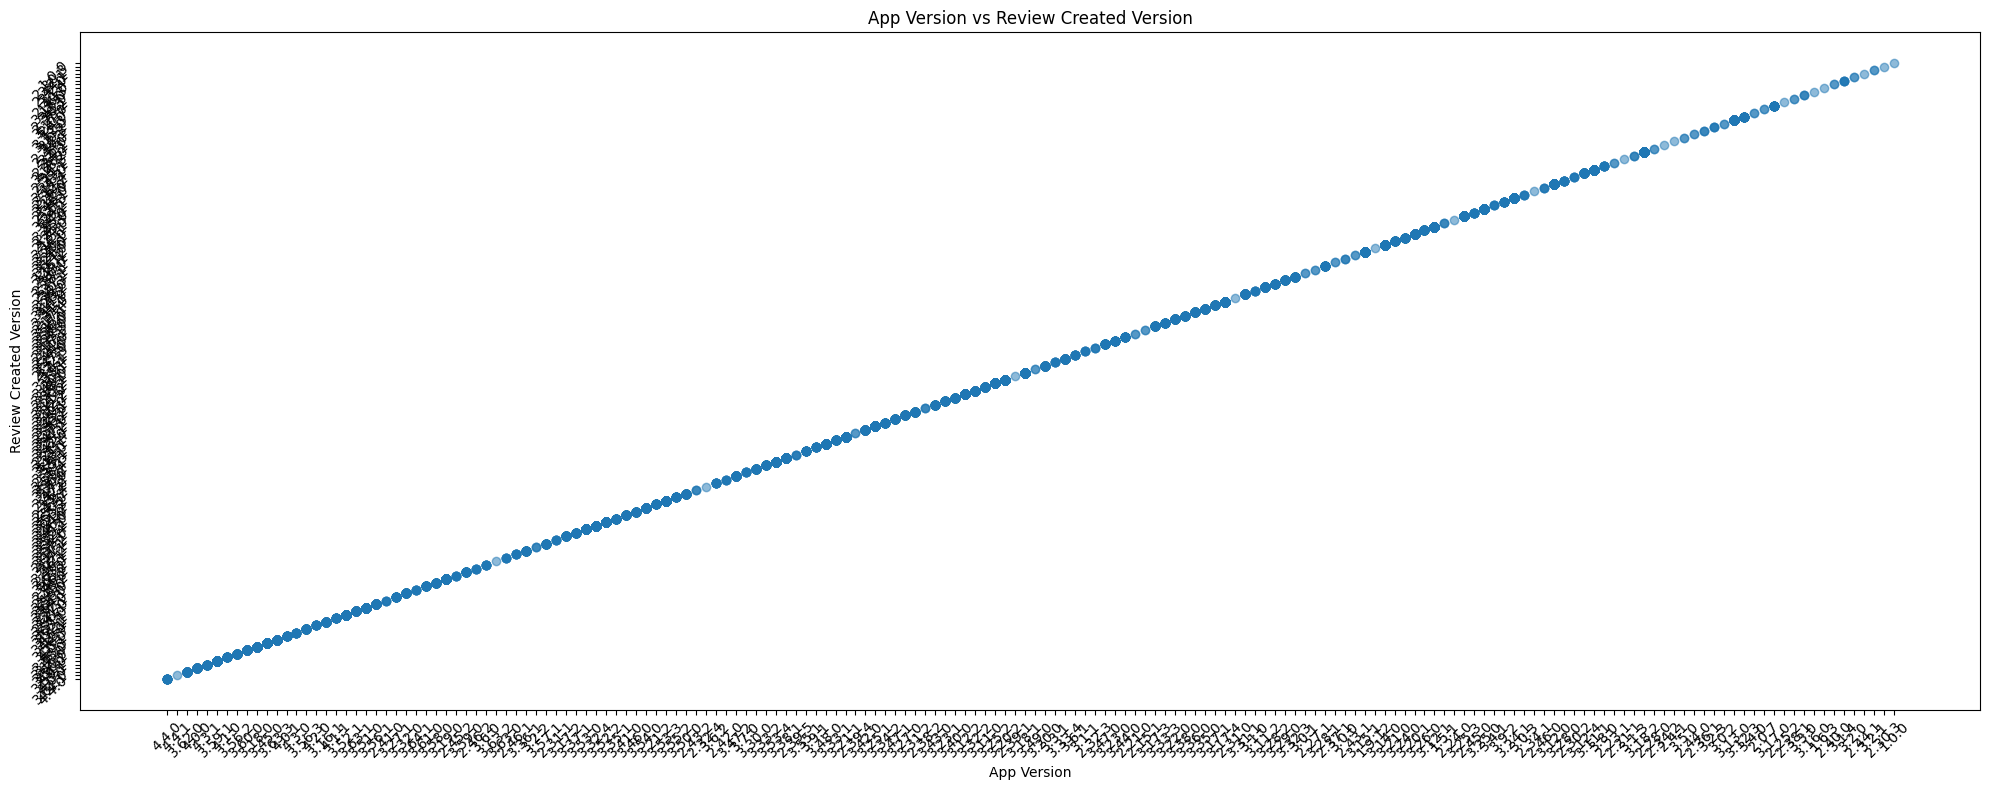

In [ ]:
plt.figure(figsize=(20,8))

plt.scatter(df['appVersion'].dropna(), df['reviewCreatedVersion'].dropna(), alpha=0.5)
plt.xlabel('App Version')
plt.ylabel('Review Created Version')
plt.title("App Version vs Review Created Version")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()


plt.show()

Abaikan label pada x dan y axis, dalam hal ini kita hanya ingin melihat korelasi antara app version dan reviewcreatedversion. Diagonal menunjukkan konsistensi antara versi aplikasi yang saat ini terinstall dan versi aplikasi saat review ditulis.

In [ ]:
app_version_counts = df.groupby(['score', 'appVersion']).size().reset_index(name='counts')
app_version_counts_sorted = app_version_counts.sort_values(by=['score', 'counts'], ascending=[True, False])

top_5_app_version_for_each_score = app_version_counts_sorted.groupby('score').head(5)
top_5_app_version_for_each_score

,score,appVersion,counts
103,1,3.38.1,196
133,1,3.59.1,158
38,1,3.11.1,120
110,1,3.45.0,99
47,1,3.15.1,94
257,2,3.59.1,27
172,2,3.11.1,21
235,2,3.45.0,20
212,2,3.31.1,18
229,2,3.38.1,16


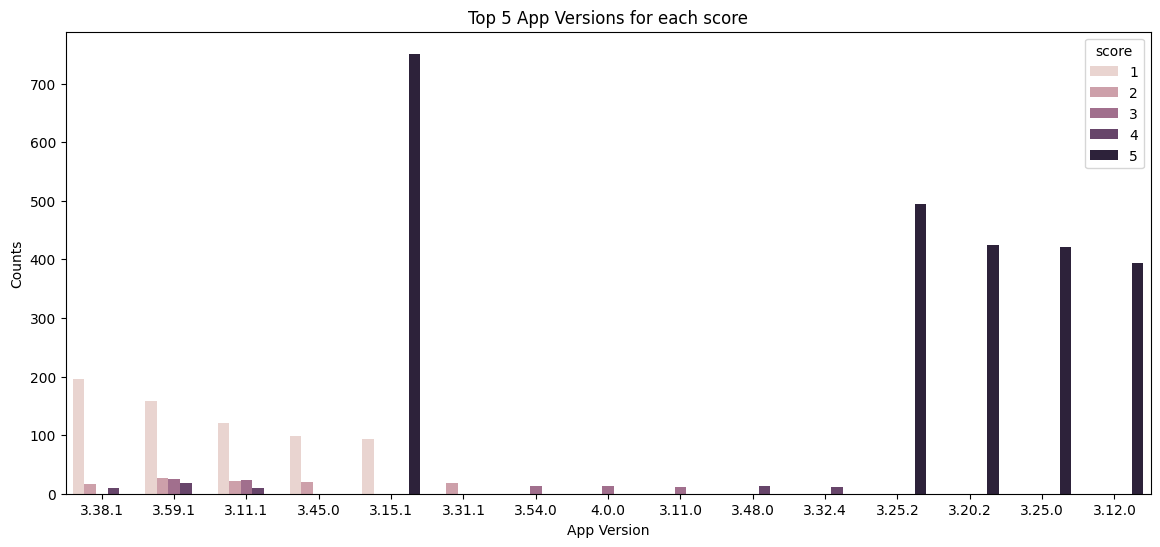

In [ ]:
plt.figure(figsize=(14,6))
sns.barplot(data=top_5_app_version_for_each_score, x='appVersion', y='counts', hue='score')
plt.xlabel('App Version')
plt.ylabel('Counts')
plt.title('Top 5 App Versions for each score')
plt.show()

## Data Preparation

Sentiment Analysis, asumsi dimana
- Rating 1,2  = Negative
- Rating 3 = Netral
- Rating 4, 5 = Positive

In [ ]:
#  read the language processing resources
combined_stopwords = '/content/drive/MyDrive/Datasets/dictionary/combined_stop_words.txt'
combined_slang_words = '/content/drive/MyDrive/Datasets/dictionary/combined_slang_words.txt'
df_kamus_alay = pd.read_csv('/content/drive/MyDrive/Datasets/colloquial-indonesian-lexicon.csv')


In [ ]:
# read the stopwords
with open(combined_stopwords, 'r') as file:
  stopwords_indonesian = [line.strip() for line in file.readlines()]

# update stopwords
stop_words = set(stopwords.words("indonesian"))
stop_words.update(stopwords_indonesian)
print(stop_words)
# print(stopwords_indonesian)

{'melihatnya', 'the', 'dimana', 'kemungkinan', 'dipergunakan', 'mendatang', 'jadilah', 'menggunakan', 'mungkinkah', 'terhadapnya', 'karena', 'terkira', 'inilah', 'demikianlah', 'secukupnya', 'artinya', 'supaya', 'aku', 'gimana', 'berkeinginan', 'maupun', 'dahulu', 'jadi', 'kami', 'kemungkinannya', 'sebagainya', 'mula', 'akhiri', 'terutama', 'sangat', 'jadinya', 'sejauh', 'seingat', 'sekadarnya', 'kira-kira', 'diakhirinya', 'sekadar', 'seseorang', 'pun', 'sumber', 'meyakini', 'dimulai', 'adapun', 'dimaksud', 'dimintai', 'tersampaikan', 'bertemu', 'beri', 'meningkatkan', 'ditemukan', 'perlukah', 'mengetahui', 'diingatkan', 'adanya', 'menuturkan', 'diberi', 'memungkinkan', 'akhir', 'sebut', 'olehnya', 'sebagaimana', 'sebuah', 'tinggal', 'bulan', 'hari', 'cukup', 'sekarang', 'sebisanya', 'semua', 'menegaskan', 'diketahuinya', 'tertentu', 'minta', 'mengibaratkannya', 'sebutlah', 'diingat', 'begitupun', 'memperkirakan', 'kali', 'pernah', 'baik', 'setidak-tidaknya', 'entah', 'bersiap-siap', '

In [ ]:
# read combined_slang_words
with open(combined_slang_words, 'r') as file:
  slang_dict = file.read()

#  Convert the string to a dictionary
slang_dict = json.loads(slang_dict)

print(slang_dict)

{'@': 'di', 'abis': 'habis', 'ad': 'ada', 'adlh': 'adalah', 'afaik': 'as far as i know', 'ahaha': 'haha', 'aj': 'saja', 'ajep-ajep': 'dunia gemerlap', 'ak': 'saya', 'akika': 'aku', 'akkoh': 'aku', 'akuwh': 'aku', 'alay': 'norak', 'alow': 'halo', 'ambilin': 'ambilkan', 'ancur': 'hancur', 'anjrit': 'anjing', 'anter': 'antar', 'ap2': 'apa-apa', 'apasih': 'apa sih', 'apes': 'sial', 'aps': 'apa', 'aq': 'saya', 'aquwh': 'aku', 'asbun': 'asal bunyi', 'aseekk': 'asyik', 'asekk': 'asyik', 'asem': 'asam', 'aspal': 'asli tetapi palsu', 'astul': 'asal tulis', 'ato': 'atau', 'au ah': 'tidak mau tahu', 'awak': 'saya', 'ay': 'sayang', 'ayank': 'sayang', 'b4': 'sebelum', 'bakalan': 'akan', 'bandes': 'bantuan desa', 'bangedh': 'banget', 'banpol': 'bantuan polisi', 'banpur': 'bantuan tempur', 'basbang': 'basi', 'bcanda': 'bercanda', 'bdg': 'bandung', 'begajulan': 'nakal', 'beliin': 'belikan', 'bencong': 'banci', 'bentar': 'sebentar', 'ber3': 'bertiga', 'beresin': 'membereskan', 'bete': 'bosan', 'beud': 

In [ ]:
# read kamus alay

dict_kamus_alay = dict(zip(df_kamus_alay['slang'], df_kamus_alay['formal']))
dict_kamus_alay

In [ ]:
# lemmatizing
# lemmatizer = WordNetLemmatizer()

In [ ]:
# text preprocessing
def clean_text(text, add_sw=[]):
    # lowercase all
    text = text.lower()

    # remove special characters
    text = re.sub(r'[^a-z\s]', ' ', text)

    # tokenize the text
    tokens = word_tokenize(text)

    # replace abbreviation using combined slang words
    tokens = [slang_dict.get(word.strip(), word) for word in tokens]

    # replace acronym aswell
    # tokens = [acronym_dict.get(word.strip(), word) for word in tokens]

    # replace kamus alay
    tokens = [dict_kamus_alay.get(word.strip(), word) for word in tokens]

    # lemmatizing
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # remove stopwords
    stop_words.update(add_sw)
    tokens = [word for word in tokens if word.strip() not in stop_words]

    # Join the tokens back into a string
    text = ' '.join(tokens)
    return text

In [ ]:
df['content'] = df['content'].apply(clean_text)

In [ ]:
all_cleaned_tokens = [token for tokens in df['content'].str.split() for token in tokens]

len(all_cleaned_tokens)

182717

In [ ]:
token_counts = Counter(all_cleaned_tokens)

token_counts_df = pd.DataFrame(token_counts.items(), columns=['Token', "Frequencies"])
token_counts_df = token_counts_df.sort_values(by='Frequencies', ascending=False).reset_index(drop=True)
token_counts_df

### Cleaning 1

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
token_counts_df[:75]

In [ ]:
more_sw = ['aplikasi', 'jenius', 'nya', 'e', 'aplikasinya', 'pakai', 'sih', 'apk', 'deh', 'iya', 'banget']

In [ ]:
df['content'] = df['content'].apply(clean_text, add_sw=more_sw)

In [ ]:
df['content'].head(20)

### Cleaning 2

In [ ]:
token_counts_df[75:250]

In [ ]:
more_sw = ['kayak', 'kena', 'app', 'eh', 'loh', 'min', 'ku', 'biar', 'apapun']

In [ ]:
df['content'] = df['content'].apply(clean_text, add_sw=more_sw)

### Cleaning 3

In [ ]:
token_counts_df[250:500]

In [ ]:
more_sw = ['apknya', 'tuh', 'an', 'mbak', 'mah', 'kakak', 'apps', 'ter', 'kak', 'a', 'kadang', 'apl']

In [ ]:
df['content'] = df['content'].apply(clean_text, add_sw=more_sw)

In [ ]:
df['content'].tail(20)

#### Review analysis
Asumsi
- Rating 1,2  = Negative
- Rating 3 = Netral
- Rating 4, 5 = Positive

In [ ]:
reviews = df['content']
positive = ' '.join(map(str, reviews[df['score'] > 3]))
neutral = ' '.join(map(str, reviews[df['score'] == 3]))
negative = ' '.join(map(str, reviews[df['score'] < 3]))

Text(0.5, 1.0, 'Positive Reviews')

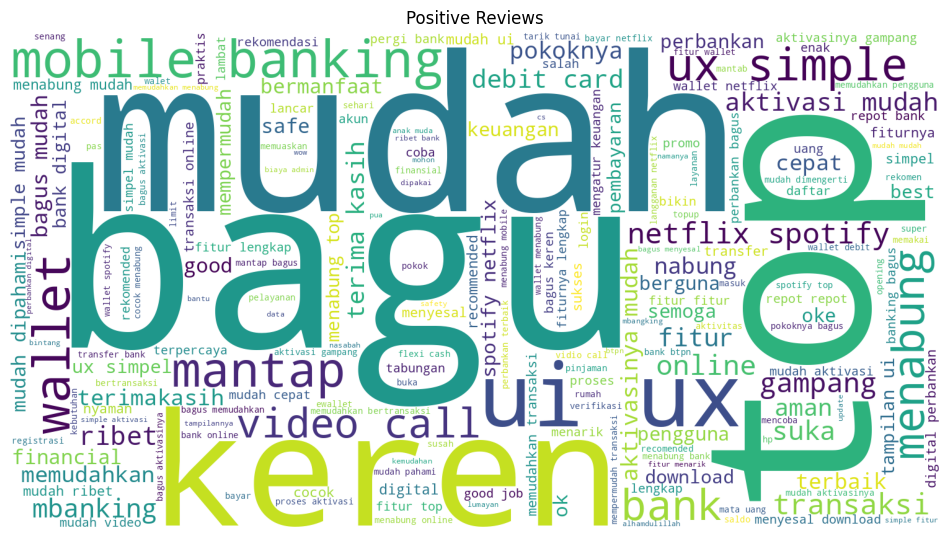

In [ ]:
positive_wordcloud = WordCloud(width=1500, height=800, background_color='white').generate(positive)
plt.figure(figsize=(12,12))
plt.imshow(positive_wordcloud)
plt.axis('off')
plt.title('Positive Reviews')

Text(0.5, 1.0, 'Neutral Reviews')

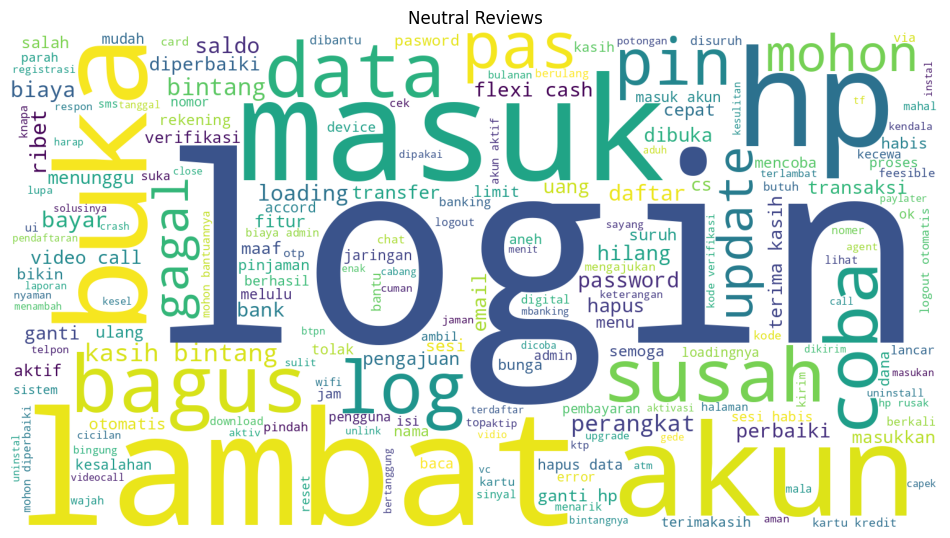

In [ ]:
neutral_wordcloud = WordCloud(width=1500, height=800, background_color='white').generate(neutral)
plt.figure(figsize=(12,12))
plt.imshow(neutral_wordcloud)
plt.axis('off')
plt.title('Neutral Reviews')

Text(0.5, 1.0, 'Negative Reviews')

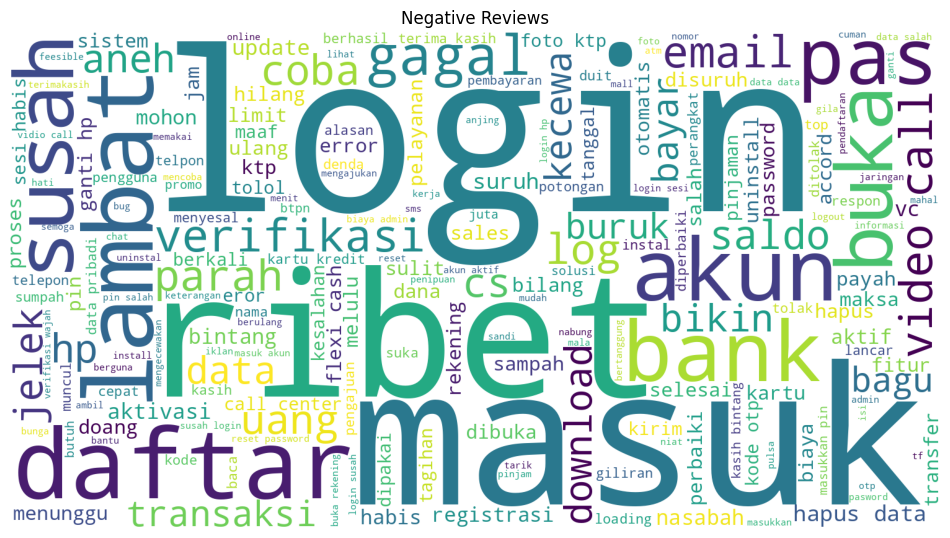

In [ ]:
negative_wordcloud = WordCloud(width=1500, height=800, background_color='white').generate(negative)
plt.figure(figsize=(12,12))
plt.imshow(negative_wordcloud)
plt.axis('off')
plt.title('Negative Reviews')

Terlihat jelas perbedaan kata kata yang muncul pada review positive dan negatif. Review netral (skor 3) lebih banyak kemiripan dengan kata kata yang ada di negative reviews.

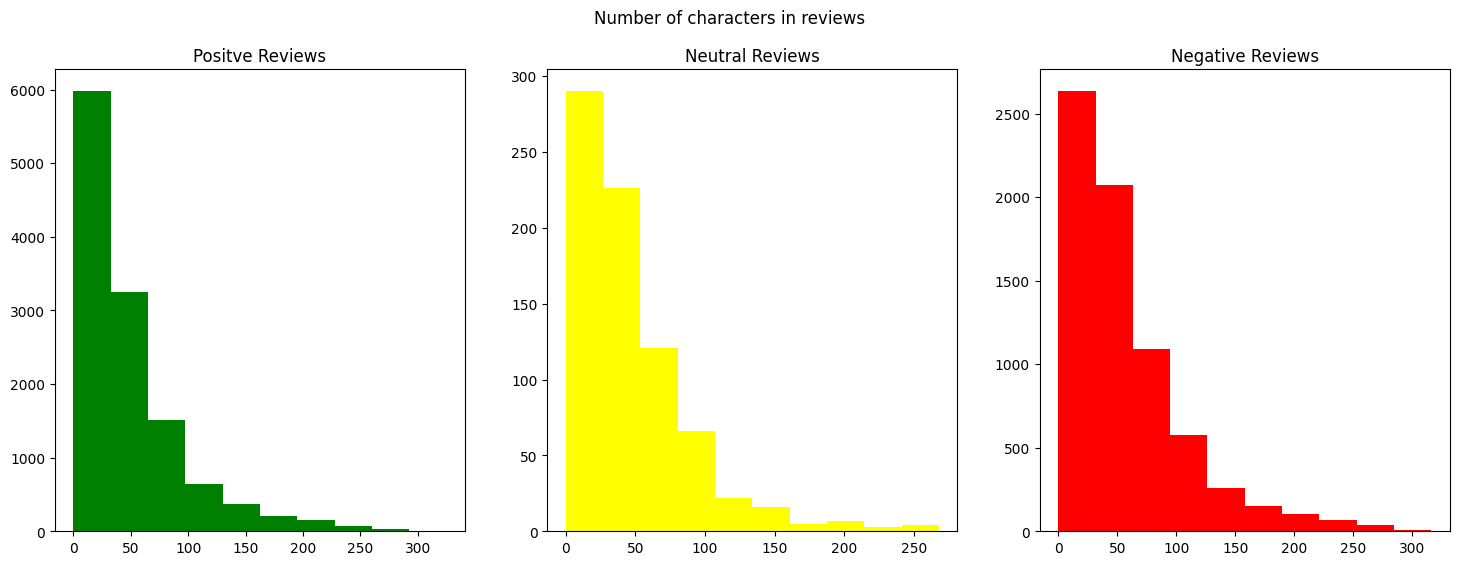

In [ ]:
# visualize number of characters in each reviews

figure,(pos_ax, neut_ax, neg_ax) = plt.subplots(1,3, figsize=(18,6))

len_pos_review = df[df['score'] > 3]['content'].str.len()
pos_ax.hist(len_pos_review, color='green')
pos_ax.set_title('Positve Reviews')

len_neut_review = df[df['score'] == 3]['content'].str.len()
neut_ax.hist(len_neut_review, color='yellow')
neut_ax.set_title('Neutral Reviews')

len_neg_review = df[df['score'] < 3]['content'].str.len()
neg_ax.hist(len_neg_review, color='red')
neg_ax.set_title('Negative Reviews')

figure.suptitle('Number of characters in reviews')
plt.show()

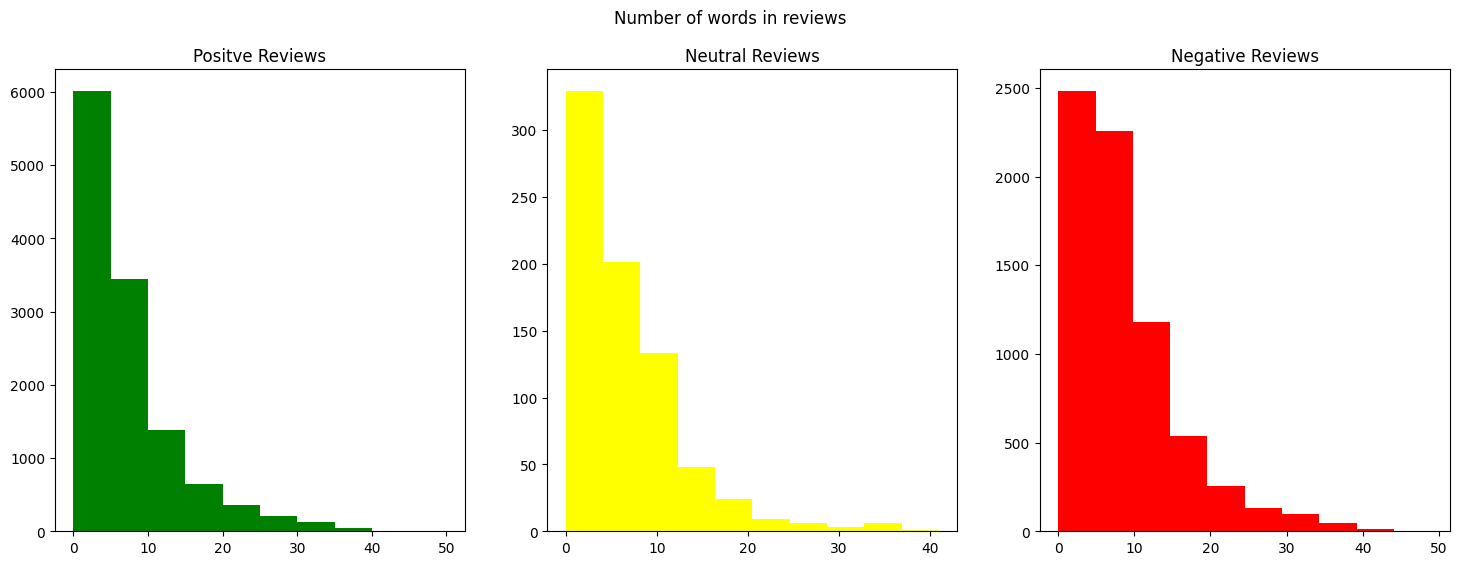

In [ ]:
# visualize number of words in review

figure,(pos_ax, neut_ax, neg_ax) = plt.subplots(1,3, figsize=(18,6))

pos_word = df[df['score'] > 3]['content'].str.split().map(lambda review: len(review))
pos_ax.hist(pos_word, color='green')
pos_ax.set_title('Positve Reviews')

neut_word = df[df['score'] == 3]['content'].str.split().map(lambda review: len(review))
neut_ax.hist(neut_word, color='yellow')
neut_ax.set_title('Neutral Reviews')

neg_word = df[df['score'] < 3]['content'].str.split().map(lambda review: len(review))
neg_ax.hist(neg_word, color='red')
neg_ax.set_title('Negative Reviews')

figure.suptitle('Number of words in reviews')
plt.show()

<ipython-input-25-cd55f5faeb63>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pos_word.map(lambda review: np.mean(review)), ax=pos_ax, color='green')
<ipython-input-25-cd55f5faeb63>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neut_word.map(lambda review: np.mean(review)), ax=neut_ax, co

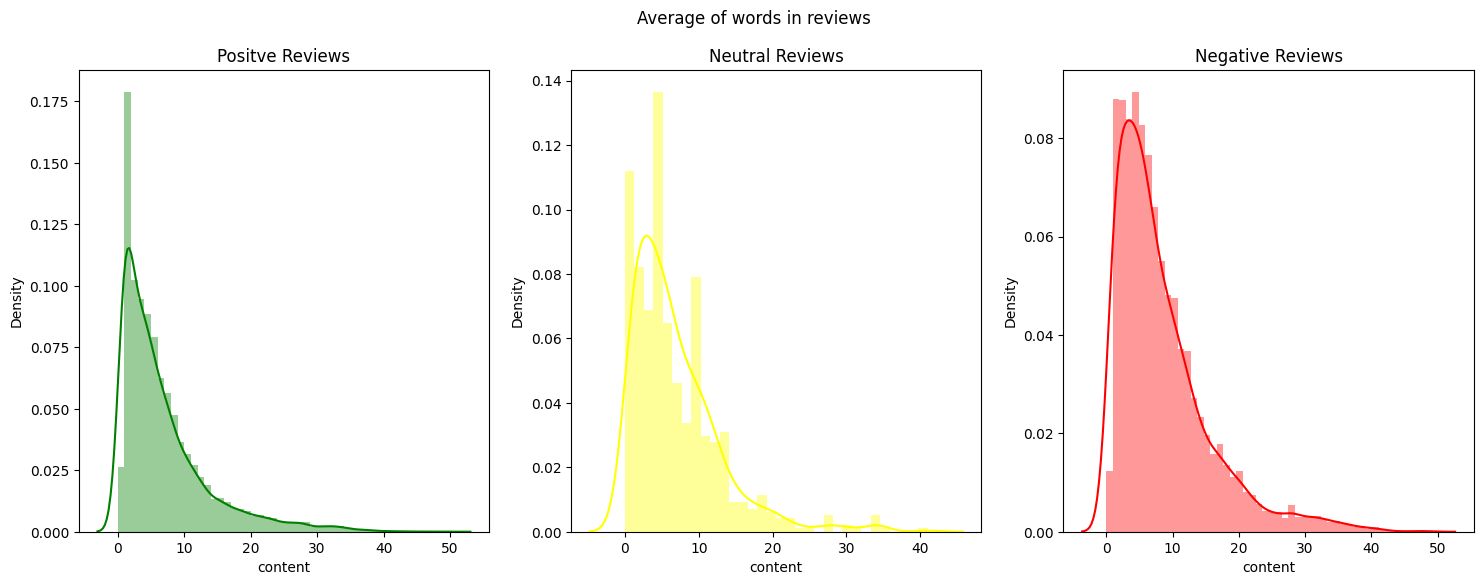

In [ ]:
# visualize average of words in review

figure,(pos_ax, neut_ax, neg_ax) = plt.subplots(1,3, figsize=(18,6))

pos_word = df[df['score'] > 3]['content'].str.split().map(lambda review: len(review))
sns.distplot(pos_word.map(lambda review: np.mean(review)), ax=pos_ax, color='green')
pos_ax.set_title('Positve Reviews')

neut_word = df[df['score'] == 3]['content'].str.split().map(lambda review: len(review))
sns.distplot(neut_word.map(lambda review: np.mean(review)), ax=neut_ax, color='yellow')
neut_ax.set_title('Neutral Reviews')

neg_word = df[df['score'] < 3]['content'].str.split().map(lambda review: len(review))
sns.distplot(neg_word.map(lambda review: np.mean(review)), ax=neg_ax, color='red')
neg_ax.set_title('Negative Reviews')

figure.suptitle('Average of words in reviews')
plt.show()

Negative reviews memiliki average word count yang lebih banyak dibandingkan positif dan netral

In [ ]:
# top text using count vectorizer

def get_top_text(corpus, n, g):
  cv=CountVectorizer(ngram_range=(g,g)).fit(corpus)
  bag_of_words = cv.transform(corpus)
  sum = bag_of_words.sum(axis=0)
  words_freq = [(word, sum[0, idx]) for word, idx in cv.vocabulary_.items()] # get n grams name and their count
  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True) # sort by frequency
  # convert to dataframe
  df_words_freq = pd.DataFrame(words_freq, columns=['Text', 'Count'])

  top_text = df_words_freq
  return top_text[:n]

In [ ]:
pd.reset_option('display.max_rows')

In [ ]:
positive_common = get_top_text(df[df['score'] > 3]['content'], 20, 1)

# visualize using ploty
fig = px.bar(positive_common,
             y='Text',
             x='Count',
             orientation='h',
             title='Top Unigram for Positive Reviews',
             color='Text',
             )
fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Text',
    xaxis_showgrid=False,
    yaxis_automargin=True,
    width=1000,
    height=600
)

fig.show()

In [ ]:
positive_common = get_top_text(df[df['score'] > 3]['content'], 20, 2)

# visualize using ploty
fig = px.bar(positive_common,
             y='Text',
             x='Count',
             orientation='h',
             title='Top Bigram for Positive Reviews',
             color='Text',
             )
fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Text',
    xaxis_showgrid=False,
    yaxis_automargin=True,
    width=1000,
    height=600
)

fig.show()

In [ ]:
positive_common = get_top_text(df[df['score'] > 3]['content'], 20, 3)

# visualize using ploty
fig = px.bar(positive_common,
             y='Text',
             x='Count',
             orientation='h',
             title='Top Trigram for Positive Reviews',
             color='Text',
             )
fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Text',
    xaxis_showgrid=False,
    yaxis_automargin=True,
    width=1000,
    height=600
)

fig.show()

In [ ]:
neutral_common = get_top_text(df[df['score']==3]['content'], 20, 1)

# visualize using ploty
fig = px.bar(neutral_common,
             y='Text',
             x='Count',
             orientation='h',
             title='Top Unigram for Neutral Reviews',
             color='Text',
             )
fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Text',
    xaxis_showgrid=False,
    yaxis_automargin=True,
    width=1000,
    height=600
)

fig.show()

In [ ]:
neutral_common = get_top_text(df[df['score']==3]['content'], 20, 2)

# visualize using ploty
fig = px.bar(neutral_common,
             y='Text',
             x='Count',
             orientation='h',
             title='Top Bigram for Neutral Reviews',
             color='Text',
             )
fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Text',
    xaxis_showgrid=False,
    yaxis_automargin=True,
    width=1000,
    height=600
)

fig.show()

In [ ]:
neutral_common = get_top_text(df[df['score']==3]['content'], 20, 3)

# visualize using ploty
fig = px.bar(neutral_common,
             y='Text',
             x='Count',
             orientation='h',
             title='Top Trigram for Neutral Reviews',
             color='Text',
             )
fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Text',
    xaxis_showgrid=False,
    yaxis_automargin=True,
    width=1000,
    height=600
)

fig.show()

In [ ]:
negative_common = get_top_text(df[df['score'] < 3]['content'], 20, 1)

# visualize using ploty
fig = px.bar(negative_common,
             y='Text',
             x='Count',
             orientation='h',
             title='Top Unigram for Negative Reviews',
             color='Text',
             )
fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Text',
    xaxis_showgrid=False,
    yaxis_automargin=True,
    width=1000,
    height=600
)

fig.show()

In [ ]:
negative_common = get_top_text(df[df['score'] < 3]['content'], 20, 2)

# visualize using ploty
fig = px.bar(negative_common,
             y='Text',
             x='Count',
             orientation='h',
             title='Top Bigram for Negative Reviews',
             color='Text',
             )
fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Text',
    xaxis_showgrid=False,
    yaxis_automargin=True,
    width=1000,
    height=600
)

fig.show()

In [ ]:
negative_common = get_top_text(df[df['score'] < 3]['content'], 20, 3)

# visualize using ploty
fig = px.bar(negative_common,
             y='Text',
             x='Count',
             orientation='h',
             title='Top Trigram for Negative Reviews',
             color='Text',
             )
fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Text',
    xaxis_showgrid=False,
    yaxis_automargin=True,
    width=1000,
    height=600
)

fig.show()

In [ ]:
def classify_sentiment(score):
  if score > 3:
    return 1
  elif score == 3:
    return 2
  else:
    return 0

In [ ]:
# classify sentiment based on score
df['Sentiment'] = df['score'].apply(classify_sentiment)
df.head(20)

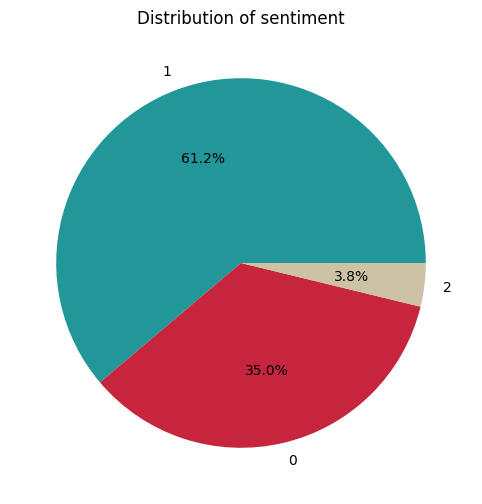

In [ ]:
# calculate sentiment distribution
sentiment_counts = df['Sentiment'].value_counts(normalize=True) * 100

# visualize using pie chart
plt.figure(figsize=(10,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#229799', '#C7253E', '#CDC2A5'])
plt.title('Distribution of sentiment')
plt.show()

In [ ]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'year_month', 'len_review_chars',
       'word_count_review', 'response_time', 'Sentiment'],
      dtype='object')

In [ ]:
df.head()

In [ ]:
# analyze if there's any patterns between reviews that has response and not

# create column indicating if the rview is replied or not
df['has_response'] = df['replyContent'].notna() & (df['replyContent'].str.strip() != '')

# compare based on length of the review (word count)
response_stats = df.groupby('has_response')['word_count_review'].describe()
response_stats

,count,mean,std,min,25%,50%,75%,max
has_response,,,,,,,,
False,18440.0,7.200054,6.847581,0.0,2.0,5.0,10.0,50.0
True,1560.0,8.318590,7.422322,0.0,3.0,6.0,11.0,48.0


In [ ]:
# compare based on sentiment
sentiment_distribution = df.groupby('has_response')['Sentiment'].describe()
sentiment_distribution

,count,mean,std,min,25%,50%,75%,max
has_response,,,,,,,,
False,18440.0,0.722668,0.522903,0.0,0.0,1.0,1.0,2.0
True,1560.0,0.276282,0.558291,0.0,0.0,0.0,0.0,2.0


75% review yang dibalas adalah review yang sentimennya adlah 0 (negatif). Sedangkan yang tidak dibalas, sentimennya cenderung positif